In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

cwd = os.getcwd()
date_format = "%Y-%m-%d"
INTERSECTION_PATH = os.path.join(cwd, "..", "data/tornadoes_and_counties_new.csv")
data_tornado = pd.read_csv(INTERSECTION_PATH)

In [67]:
#num tornados with negative magnitude (unknown)
np.sum(data_tornado['mag']<0)

796

In [68]:
# num tornados with 0 property loss
# (does NOT mean no property damage, just that it was not reported)
np.sum(data_tornado['loss'] == 0)

28910

In [69]:
np.count_nonzero(data_tornado['loss'])

49618

Text(0.5, 1.0, 'Histogram of Property Loss')

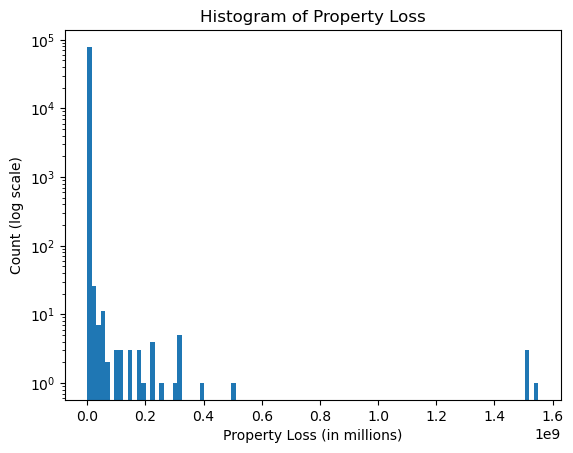

In [70]:
plt.hist(data_tornado['loss'], log=True, bins=100)
plt.xlabel('Property Loss (in millions)')
plt.ylabel('Count (log scale)')
plt.title('Histogram of Property Loss')

<Axes: xlabel='loss'>

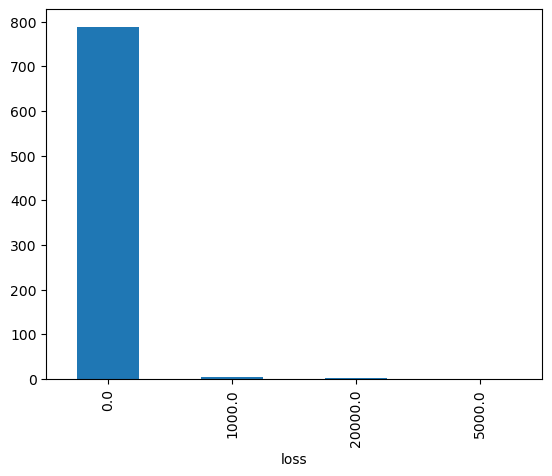

In [71]:
# tornadoes with unknown magnitude and their loss values
unknowns = data_tornado[data_tornado['mag'] == -9]
unknowns['loss'].value_counts().plot(kind='bar')

Text(0.5, 1.0, 'Histogram of Crop Loss')

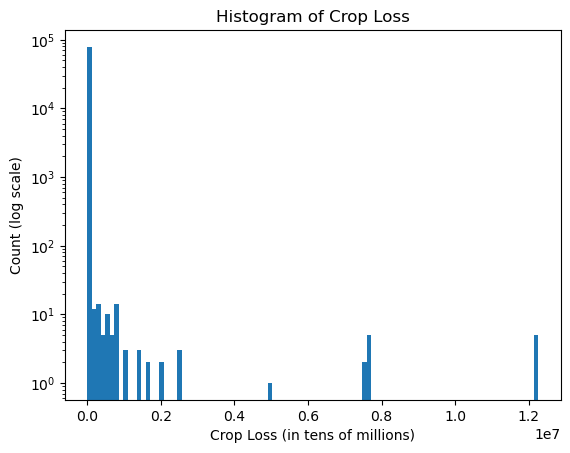

In [72]:
plt.hist(data_tornado['closs'], log=True, bins=100)
plt.xlabel('Crop Loss (in tens of millions)')
plt.ylabel('Count (log scale)')
plt.title('Histogram of Crop Loss')

Text(0.5, 1.0, 'Histogram of Fatalities')

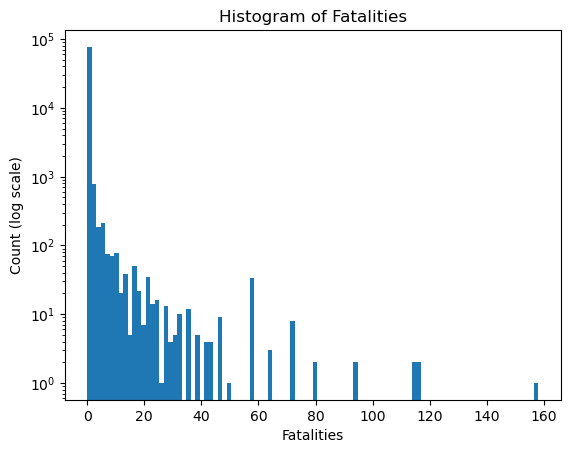

In [73]:
plt.hist(data_tornado['fat'], log=True, bins=100)
plt.xlabel('Fatalities')
plt.ylabel('Count (log scale)')
plt.title('Histogram of Fatalities')

(array([1940., 1950., 1960., 1970., 1980., 1990., 2000., 2010., 2020.,
        2030.]),
 [Text(1940.0, 0, '1940'),
  Text(1950.0, 0, '1950'),
  Text(1960.0, 0, '1960'),
  Text(1970.0, 0, '1970'),
  Text(1980.0, 0, '1980'),
  Text(1990.0, 0, '1990'),
  Text(2000.0, 0, '2000'),
  Text(2010.0, 0, '2010'),
  Text(2020.0, 0, '2020'),
  Text(2030.0, 0, '2030')])

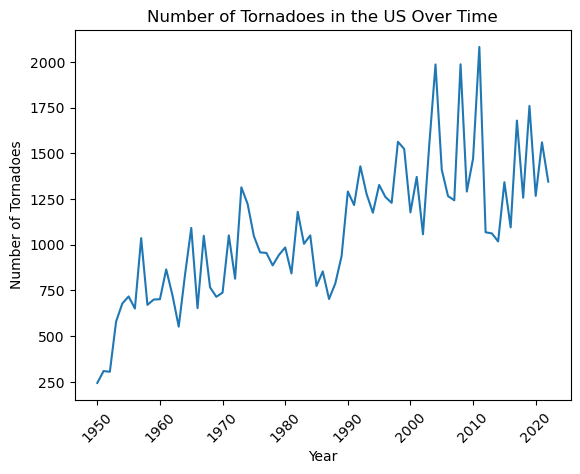

In [74]:
#tornadoes over time
tornadoes_by_year = data_tornado['yr'].value_counts().sort_index()
# print(tornadoes_by_year)
plt.plot(tornadoes_by_year.index, tornadoes_by_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Tornadoes')
plt.title('Number of Tornadoes in the US Over Time')
plt.xticks(rotation=45)


Text(0.5, 1.0, 'Number of Tornadoes per month in the US')

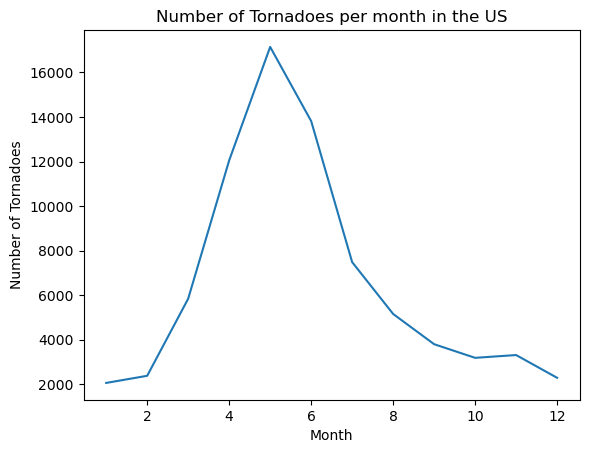

In [75]:
#tornadoes by month
tornadoes_by_month = data_tornado['mo'].value_counts().sort_index()
plt.plot(tornadoes_by_month.index, tornadoes_by_month.values)
plt.xlabel('Month')
plt.ylabel('Number of Tornadoes')
plt.title('Number of Tornadoes per month in the US')

In [76]:
#get total number of tornadoes per month
date_tornado_copy = data_tornado.copy()
date_tornado_copy['date'] = pd.to_datetime(data_tornado['date'], format=date_format)
data_tornado_monthly = date_tornado_copy.set_index('date').resample('ME').size()

In [77]:
data_tornado_monthly

date
1950-01-31     9
1950-02-28    34
1950-03-31    28
1950-04-30    16
1950-05-31    67
              ..
2022-08-31    37
2022-09-30    26
2022-10-31    36
2022-11-30    77
2022-12-31    67
Freq: ME, Length: 876, dtype: int64

In [78]:
#number of years covered
num_years = data_tornado['yr'].nunique()
num_years

73

In [79]:
#get average number of tornadoes per month
avg_num_tornadoes_per_month = data_tornado.groupby('mo').size() / num_years
avg_num_tornadoes_per_month


mo
1      28.246575
2      32.630137
3      80.027397
4     165.068493
5     234.835616
6     189.246575
7     102.520548
8      70.643836
9      52.054795
10     43.671233
11     45.383562
12     31.397260
dtype: float64

<Axes: xlabel='date'>

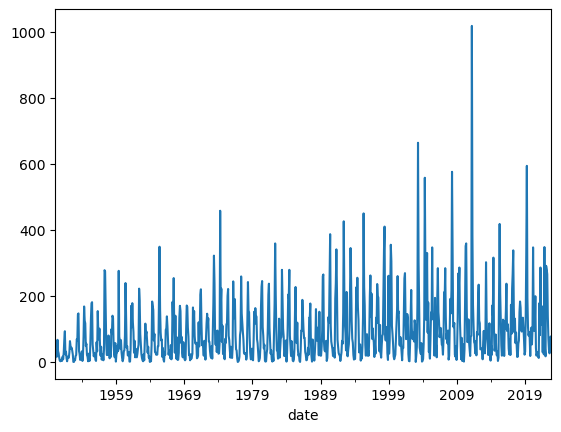

In [80]:
data_tornado_monthly.plot()

In [81]:
import scipy.interpolate as spi

x = avg_num_tornadoes_per_month.index.astype(int)
y = avg_num_tornadoes_per_month.values

#artificially moving the first value to the end to make the interpolation smoother
y[-1] = y[0]
P = spi.CubicSpline(x, y, bc_type='periodic')
plotting_x = np.linspace(0, 24, 100)


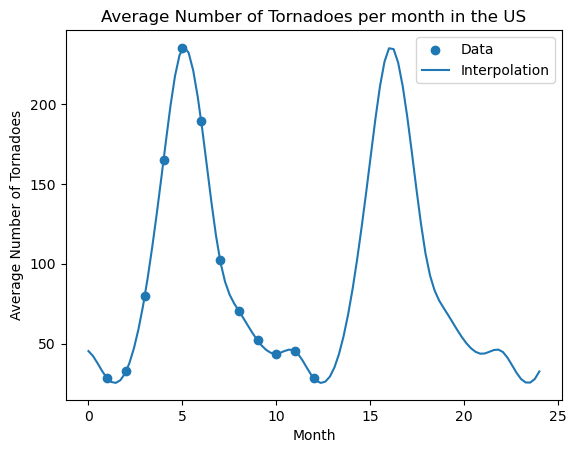

In [82]:
plt.scatter(avg_num_tornadoes_per_month.index, avg_num_tornadoes_per_month.values)
plt.plot(plotting_x, P(plotting_x))
plt.xlabel('Month')
plt.ylabel('Average Number of Tornadoes')
plt.title('Average Number of Tornadoes per month in the US')
plt.legend(['Data', 'Interpolation'])

In [83]:
data_tornado_monthly

date
1950-01-31     9
1950-02-28    34
1950-03-31    28
1950-04-30    16
1950-05-31    67
              ..
2022-08-31    37
2022-09-30    26
2022-10-31    36
2022-11-30    77
2022-12-31    67
Freq: ME, Length: 876, dtype: int64

In [84]:
data_tornado_monthly.size

876

In [85]:
samples = np.arange(1, data_tornado_monthly.size+1)

In [86]:
#de-periodize the data
# treat 1 as January
data_tornado_monthly_deperiodized = data_tornado_monthly - P(samples % 12)

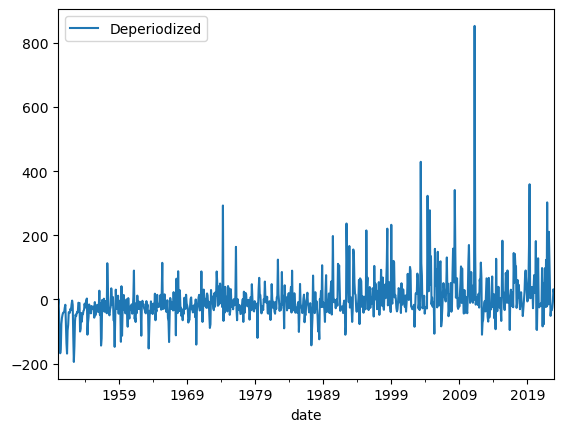

In [87]:
data_tornado_monthly_deperiodized.plot()
# data_tornado_monthly.plot()
# plt.plot(samples[:100], P(samples)[:100])
plt.legend(['Deperiodized', 'Data', 'Interpolation'])

In [88]:
#instead, try deperiodizing the data by subtracting each month by the number of tornados in the month 12 months before
data_tornado_monthly_deperiodized_2 = data_tornado_monthly - data_tornado_monthly.shift(12).fillna(0)

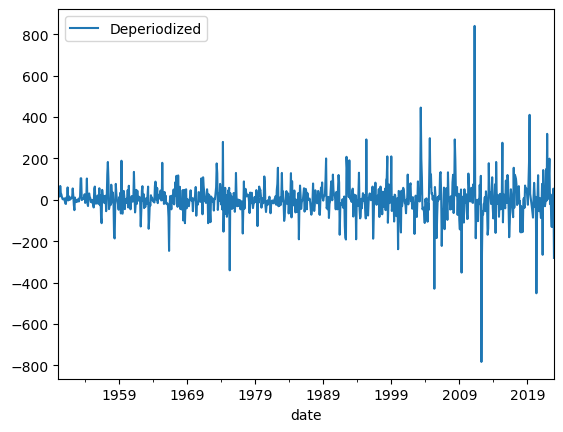

In [89]:
data_tornado_monthly_deperiodized_2.plot()
# data_tornado_monthly.plot()
plt.legend(['Deperiodized', 'Data', 'Interpolation'])


In [108]:
def get_monthly_tornadoes_for_county(data, geoid):
    county_data = data[data['GEOID'] == geoid]
    date_tornado_copy = county_data.copy()
    date_tornado_copy['date'] = pd.to_datetime(county_data['date'], format=date_format)
    county_data_monthly = date_tornado_copy.set_index('date').resample('ME').size()
    return county_data_monthly

def get_monthly_period(data):
    avg_num_tornadoes_per_month = data.groupby('mo').size() / num_years
    print(avg_num_tornadoes_per_month)

    x = avg_num_tornadoes_per_month.index.astype(int)
    y = avg_num_tornadoes_per_month.values

    #artificially moving the first value to the end to make the interpolation smoother
    y[-1] = y[0]
    P = spi.CubicSpline(x, y, bc_type='periodic')
    return P

In [109]:
data_tornado['GEOID'].value_counts()
#look at counties 8123, 48201, 8121, 12099, 8001

GEOID
8123     288
48201    249
8121     183
12099    181
8001     172
        ... 
2261       1
54021      1
8097       1
36073      1
54069      1
Name: count, Length: 3057, dtype: int64

In [110]:
county_monthly = get_monthly_tornadoes_for_county(data_tornado, 8123)
county_period_func = deperiodize_monthly_tornadoes(county_monthly)
county_monthly[:200].plot()

TypeError: Converting from datetime64[ns] to int32 is not supported. Do obj.astype('int64').astype(dtype) instead